In [1]:
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipkinc, ellipeinc, ellipk

In [2]:
def midpoint_method(func,args:Dict, __x,__y,__ind):
    new_x = __x
    new_y = __y
    x_ = [new_x[__ind],new_x[__ind+1]]
    inbetween_x = np.mean(x_)
    new_x.insert(__ind+1,inbetween_x)
    y_ = [new_y[__ind],new_y[__ind+1]]
    inbetween_solution = func(inbetween_x, **args)
    new_y.insert(__ind+1,inbetween_solution)
    y_.insert(1, inbetween_solution)
    ind_of_sign_change_ =np.where(np.diff(np.sign(y_)))[0]
    print(ind_of_sign_change_,np.where(np.diff(np.sign(y_))),np.diff(np.sign(y_)),np.sign(y_),y_)
    new_ind=__ind + ind_of_sign_change_[0]
    return new_x, new_y, new_ind

def find_multiple_roots(func, args:Dict, start, end, step, tol=1e-6):
    """
    Finds multiple roots of the function `func` in the range [start, end].
    """
    roots = []
    x = start
    while x < end:
        x_next = x + step
        if func(x) * func(x_next) < 0:  # Root exists in [x, x_next]
            try:
                root = bisection_method(func, x, x_next, tol)
                roots.append(root)
            except ValueError:
                pass  # Skip intervals where the method fails
        x = x_next
    return roots

def improve_solutions_midpoint(func, args, x, y, index_of_sign_change, iterations) -> float:
    new_x =x
    new_y =y
    new_ind = index_of_sign_change
    for iteration in range(iterations):
        new_x, new_y, new_ind = midpoint_method(func=func, args=args, __x=new_x, __y=new_y, __ind = new_ind)
    updated_P = new_x[new_ind]
    return updated_P

def f(x):
    return x**2-1

In [3]:
def bisection_method(func, _r,_alpha, bh_mass, incl, n, a, b, tol):
    if func(a, _r,_alpha, bh_mass, incl, n) * func(b, _r,_alpha, bh_mass, incl, n) >= 0:
        print("Bisection method fails. The function must have opposite signs at a and b.")
        return None

    while (b - a) / 2 > tol:
        midpoint = (a + b) / 2
        if func(midpoint, _r,_alpha, bh_mass, incl, n,) == 0:  # Found exact root
            return midpoint
        elif func(a, _r,_alpha, bh_mass, incl, n) * func(midpoint, _r,_alpha, bh_mass, incl, n) < 0:
            b = midpoint
        else:
            a = midpoint

    return (a + b) / 2

def find_multiple_roots(func, _r,_alpha, bh_mass, incl, n, start, end, step, tol=1e-6):
    roots = []
    x = start
    while x < end:
        x_next = x + step
        if func(x, _r,_alpha, bh_mass, incl, n) * func(x_next, _r,_alpha, bh_mass, incl, n) < 0:  # Root exists in [x, x_next]
            try:
                root = bisection_method(func, _r,_alpha, bh_mass, incl, n, x, x_next, tol)
                roots.append(root)
            except ValueError:
                pass  # Skip intervals where the method fails
        x = x_next
    return roots

In [4]:
def calcQ(P: float,bh_mass: float, tol=1e-3) ->float:
    Q=np.sqrt((P - 2.*bh_mass)*(P + 6.*bh_mass))
    return Q

def bfromP(P: float,bh_mass: float, tol: float=1e-5) ->float:
    b = np.sqrt(P**3/(P - 2.*bh_mass))
    return b

def zetainf(P: float,bh_mass: float, tol=1e-6) ->float:
    Q = calcQ(P,bh_mass)
    arg =(Q-P+2.*bh_mass)/(Q-P + 6.*bh_mass)
    z_inf = np.arcsin(np.sqrt(arg))
    return z_inf

def k(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k = np.sqrt((Q-P+6*bh_mass)/(2*Q))
    return k

def k2(P: float,bh_mass: float) ->float:
    Q = calcQ(P,bh_mass)
    k2 = (Q-P+6*bh_mass)/(2*Q)
    return k2

def cosgamma(_a: float, incl: float, tol=1e-5) -> float:
    if abs(incl) <tol:
        return 0
    return np.cos(_a)/np.sqrt(np.cos(_a)**2+1/(np.tan(incl)**2))

def eq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=g/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)

def calcP(_r, incl, _alpha, bh_mass, n=0, min_P=3.001, step=0.001) -> float:
    Periastrons = find_multiple_roots(eq13, _r, _alpha, bh_mass, incl, n, min_P, 2*_r, step, tol=1e-6)
    return Periastrons

def ellipse(r,a,incl):
    g=np.arccos(cosgamma(a,incl))
    b_=r*np.sin(g)
    return b_

def calcb(_r, incl, _alpha, bh_mass, n, min_P, step) -> float:
    periastrons = calcP(_r,incl,_alpha,bh_mass, n,min_P,step)
    for i in range(len(periastrons)):
        b=np.empty(len(periastrons))
        if periastrons[i] is None or periastrons[i] <=2.*bh_mass:
            b[i]= ellipse(_r, _alpha,incl)
        elif periastrons[i] >2.*bh_mass:
            b[i]=bfromP(periastrons[i], bh_mass)
        else:
            raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")
        return b

/opt/conda/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


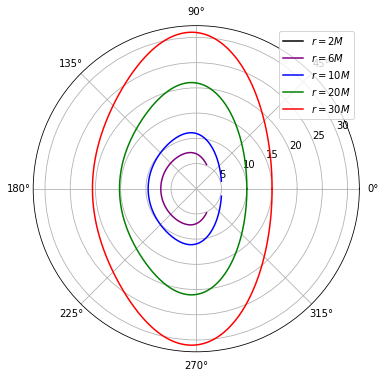

In [59]:
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_30 = []
isoradials_6_30 = []
isoradials_10_30 = []
isoradials_20_30 = []
isoradials_30_30 = []

for i in range(0,1000):
    isoradials_2_30.append(calcb(2, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_6_30.append(calcb(6, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_10_30.append(calcb(10, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_20_30.append(calcb(20, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_30_30.append(calcb(30, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_30, color= 'black', label="$r=2M$")
ax.plot(alphas, isoradials_6_30, color= 'purple', label="$r=6M$")
ax.plot(alphas, isoradials_10_30, color= 'blue', label="$r=10M$")
ax.plot(alphas, isoradials_20_30, color= 'green', label="$r=20M$")
ax.plot(alphas, isoradials_30_30, color= 'red', label="$r=30M$")
plt.legend()
plt.show()

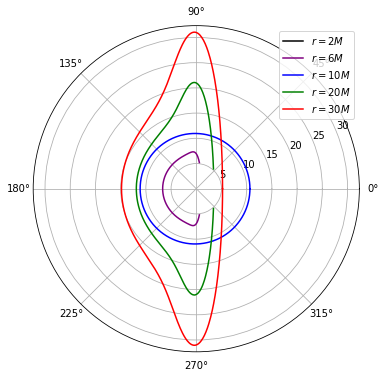

In [60]:
alphas = np.linspace(0, 2*np.pi, 1000)
isoradials_2_10 = []
isoradials_6_10 = []
isoradials_10_10 = []
isoradials_20_10 = []
isoradials_30_10 = []

for i in range(0,1000):
    isoradials_2_10.append(calcb(2, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_6_10.append(calcb(6, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_10_10.append(calcb(10, 4*np.pi/93, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_20_10.append(calcb(20, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_30_10.append(calcb(30, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001))

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_10, color= 'black', label="$r=2M$")
ax.plot(alphas, isoradials_6_10, color= 'purple', label="$r=6M$")
ax.plot(alphas, isoradials_10_10, color= 'blue', label="$r=10M$")
ax.plot(alphas, isoradials_20_10, color= 'green', label="$r=20M$")
ax.plot(alphas, isoradials_30_10, color= 'red', label="$r=30M$")
plt.legend()
plt.show()

In [5]:
def correction(P: float, bh_mass: float, ir_radius: float) -> float:
    b = bfromP(P, bh_mass)
    h = (((b**2+6*cmath.sqrt(81-3*b**2)-54)*b)**(1/3))/b
    a1 = (((b**2+6*cmath.sqrt(81-3*b**2)-54)*b)**(1/3))/b
    a2 = 1/3*(cmath.sqrt(complex(0,-3/(h-1/h)*(complex(1/ir_radius+h/2+1/(2*h)-1,np.sqrt(3)/2*(h-1/h))))))
    a3 = cmath.sqrt(complex(0,2*np.sqrt(3)/complex(3*h+3/h,np.sqrt(3)*(h-1/h))))
    a4 = 1/cmath.sqrt(2/(ir_radius**3) -1/(ir_radius**2)+1/(b**2))
    a5 = (h/6 +1/(6*h)+1/6)
    a6 = cmath.sqrt(-((1/ir_radius+h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*(1/ir_radius-a5)/complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a7 = cmath.sqrt(-((1/ir_radius+h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*(1/ir_radius-a5)*complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a8 = a4*ellipkinc(a2.real,a3.real)*(a6*(complex(0,4*np.sqrt(3)*((b**2+60)/(b**-27))/(3*b**2))+complex(0,32*np.sqrt(3)/(5*b**2)))+a5*(1/45-2/(3*b**2)+a5/(15*b**4)))
    a9 = a4*ellipeinc(a2.real,a3.real)*(a6*(112*np.sqrt(3)/45)+a7*complex(0,(4*np.sqrt(3)*(b**2+4)/(15*b**4))-4*np.sqrt(3)*(11*b**2-36)/(3*b**2*(b**2-27))))
    a10 = 2*(2*a4*(11*b**2-36)/ir_radius**2-(b**2+60)/ir_radius-b**2+2)/(b**2*(b**2-27))
    a11= 56/(15*a4)
    a12 = 8/(5*ir_radius*a4)
    a02 = 1/3*(cmath.sqrt(complex(0,-3/(h-1/h)*(complex(h/2+1/(2*h)-1,np.sqrt(3)/2*(h-1/h))))))
    a06 = cmath.sqrt(((h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*a5/complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a07 = cmath.sqrt(((h/12+1/(12*h)-1/6)**2+3/4*(h/6-1/(6*h))**2)*a5*complex(h/4+1/(4*h),np.sqrt(3)/2*(h/6-1/(6*h))))
    a08 = a4*ellipkinc(a02.real,a3.real)*(a06*complex(0,(4*np.sqrt(3)*((b**2+60)/(b**-27))/(3*b**2))+32*np.sqrt(3)/(5*b**2))+a5*(1/45-2/(3*b**2)+a5/(15*b**4)))
    a09 = a4*ellipeinc(a02.real,a3.real)*(a06*(112*np.sqrt(3)/45)+a07*complex(0,(4*np.sqrt(3)*(b**2+4)/(15*b**4))-4*np.sqrt(3)*(11*b**2-36)/(3*b**2*(b**2-27))))
    a010 = 2*(b**2-2)/(b*(b**2-27))
    a011 = 56/(15*b)
    I = a8+a9+a10+a11+a12-b*a08-b*a09-a010-a011
    if np.isnan(I.real):
        return 1
    else:
        return I.real

def correctedeq13(P: float, ir_radius: float,ir_angle: float, bh_mass: float,incl: float, n: int=0, tol=10e-6) -> float:
    z_inf = zetainf(P,bh_mass)
    Q = calcQ(P,bh_mass)
    m_ = k2(P,bh_mass)
    ell_inf = ellipkinc(z_inf,m_)
    g = np.arccos(cosgamma(ir_angle, incl))
    I = correction(P, bh_mass, ir_radius)
    if n:
        ell_k = ellipk(m_)
        ellips_arg = (g-0.01*I-2.*n*np.pi)/(2.*np.sqrt(P/Q))-ell_inf+2.*ell_k
    else:
        ellips_arg=(g+0.01*I)/(2.*np.sqrt(P/Q)) +ell_inf
    sn,cn,dn,ph = ellipj(ellips_arg, m_)
    sn2 = sn*sn
    term1 = -(Q-P+2.*bh_mass)/(4.*bh_mass*P)
    term2 =((Q-P+6*bh_mass)/(4.*bh_mass*P))*sn2
    return 1.-ir_radius*(term1+term2)
                                                                                                                      
def calccorrectedP(_r, incl, _alpha, bh_mass, n=0, min_P=3.001, step=0.001) -> float:
    Periastrons = find_multiple_roots(correctedeq13, _r, _alpha, bh_mass, incl, n, min_P, 2*_r, step, tol=1e-6)
    return Periastrons
                                                                                                                    
def calccorrectedb(_r, incl, _alpha, bh_mass, n, min_P, step) -> float:
    periastrons = calcP(_r,incl,_alpha,bh_mass, n,min_P,step)
    for i in range(len(periastrons)):
        b=np.empty(len(periastrons))
        if periastrons[i] is None or periastrons[i] <=2.*bh_mass:
            b[i]= ellipse(_r, _alpha,incl)
        elif periastrons[i] >2.*bh_mass:
            b[i]=bfromP(periastrons[i], bh_mass)
        else:
            raise ValueError("no solution was found for P ar (r,a)=({_r}, {_alpha}) and incl = {incl}")
        return b

In [ ]:
#t = 0.01
#let's try the second method this time

alphas = np.linspace(0, 2*np.pi, 1000)


isoradials_2_30 = []
isoradials_6_30 = []
isoradials_10_30 = []
isoradials_20_30 = []
isoradials_30_30 = []

for i in range(0,1000):
    isoradials_2_30.append(calcb(2, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_6_30.append(calcb(6, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_10_30.append(calcb(10, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_20_30.append(calcb(20, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))
    isoradials_30_30.append(calcb(30, np.pi/3, alphas[i], 1, 0, 3.001, 0.001))

correctedisoradials_2_30 = np.empty(1000)
correctedisoradials_6_30 = np.empty(1000)
correctedisoradials_10_30 = np.empty(1000)
correctedisoradials_20_30 = np.empty(1000)
correctedisoradials_30_30 = np.empty(1000)

for i in range(0,1000):
    correctedisoradials_2_30[i]= calccorrectedb(2, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001)
    correctedisoradials_6_30[i]= calccorrectedb(6, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001)
    correctedisoradials_10_30[i]= calccorrectedb(10, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001)
    correctedisoradials_20_30[i]= calccorrectedb(20, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001)
    correctedisoradials_30_30[i]= calccorrectedb(30, 4*np.pi/9, alphas[i], 1, 0, 3.001, 0.001)

plt.figure(figsize=(6,6))
ax = plt.subplot(111,polar=True)
ax.plot(alphas, isoradials_2_30, color= 'red')
ax.plot(alphas, isoradials_6_30, color= 'red')
ax.plot(alphas, isoradials_10_30, color= 'red')
ax.plot(alphas, isoradials_20_30, color= 'red')
ax.plot(alphas, isoradials_30_30, color= 'red')
ax.plot(alphas, correctedisoradials_2_30, color= 'blue')
ax.plot(alphas, correctedisoradials_6_30, color= 'blue')
ax.plot(alphas, correctedisoradials_10_30, color= 'blue')
ax.plot(alphas, correctedisoradials_20_30, color= 'blue')
ax.plot(alphas, correctedisoradials_30_30, color= 'blue')
plt.show()